In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import time

# Modeling Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import catboost as cb

# Ensure models directory exists
os.makedirs('models', exist_ok=True)

print("Libraries imported successfully.")

Libraries imported successfully.


In [12]:
# Load the data processed in 02_preprocessing.ipynb
print("Loading processed data from pickle...")
train_df = pd.read_pickle('../data/processed/train_processed.pkl')

print(f"Data Loaded. Shape: {train_df.shape}")

# Sanity Check: Ensure no NaNs remaining that might crash models
if train_df.isnull().sum().sum() > 0:
    print("Warning: NaNs found. Filling with defaults...")
    train_df.fillna(0, inplace=True)
else:
    print("No NaNs found. Data is clean.")

Loading processed data from pickle...
Data Loaded. Shape: (18342124, 24)
No NaNs found. Data is clean.


In [13]:
class EnergyModelFactory:
    def __init__(self):
        pass
        
    def get_model(self, model_name, params=None):
        if params is None:
            params = {}
            
        if model_name == 'random_forest':
            # RF is very slow on large data. We limit depth/estimators for this demo.
            return RandomForestRegressor(
                n_estimators=params.get('n_estimators', 30),
                max_depth=params.get('max_depth', 12),
                n_jobs=-1,
                random_state=42
            )
            
        elif model_name == 'lightgbm':
            return lgb.LGBMRegressor(
                n_estimators=params.get('n_estimators', 1000),
                learning_rate=params.get('learning_rate', 0.1),
                num_leaves=params.get('num_leaves', 40),
                random_state=42,
                n_jobs=-1
            )
            
        
        elif model_name == 'catboost':
            return cb.CatBoostRegressor(
                iterations=params.get('iterations', 800),
                learning_rate=params.get('learning_rate', 0.1),
                depth=params.get('depth', 8),
                loss_function='RMSE',
                verbose=0, # Silent training
                allow_writing_files=False,
                random_state=42
            )
        else:
            raise ValueError(f"Model {model_name} not implemented")

    def evaluate(self, y_true, y_pred):
        """
        Calculates Root Mean Squared Logarithmic Error (RMSLE).
        Since our target is already log-transformed, this is just RMSE.
        """
        return np.sqrt(mean_squared_error(y_true, y_pred))

In [14]:
# 1. Define Features and Target
target_col = 'meter_reading'
drop_cols = [target_col, 'timestamp'] # timestamp not needed for tree models, we have cyclicals

# 2. Time Series Split
# We train on first 9 months, validate on last 3 months
split_date = '2016-10-01'

train_mask = train_df['timestamp'] < split_date
val_mask = train_df['timestamp'] >= split_date

X_train = train_df[train_mask].drop(drop_cols, axis=1)
# Apply Log Transform to Target!
y_train = np.log1p(train_df[train_mask][target_col])

X_val = train_df[val_mask].drop(drop_cols, axis=1)
y_val = np.log1p(train_df[val_mask][target_col])

print(f"Training Data: {X_train.shape}")
print(f"Validation Data: {X_val.shape}")

Training Data: (13591848, 22)
Validation Data: (4750276, 22)


In [15]:
factory = EnergyModelFactory()
model_names = ['random_forest', 'lightgbm', 'catboost']
results = {}

print("Starting Model Comparison...")
print("-" * 50)

for name in model_names:
    start_time = time.time()
    print(f"Training {name}...")
    
    # Special Handling for Random Forest: Downsampling
    # RF cannot handle 15M rows efficiently without massive RAM.
    if name == 'random_forest':
        print("   -> Downsampling data for Random Forest (10% sample)...")
        # Use a random sample of 10% of the data
        sample_idx = X_train.sample(frac=0.1, random_state=42).index
        X_t, y_t = X_train.loc[sample_idx], y_train.loc[sample_idx]
    else:
        X_t, y_t = X_train, y_train

    # Get and Fit
    model = factory.get_model(name)
    model.fit(X_t, y_t)
    
    # Predict
    preds = model.predict(X_val)
    
    # Evaluate
    # Clip negative predictions to 0 (can happen with trees)
    preds = np.maximum(0, preds)
    score = factory.evaluate(y_val, preds)
    
    elapsed = time.time() - start_time
    results[name] = score
    
    print(f"   -> Done. RMSLE: {score:.4f} (Time: {elapsed:.1f}s)")
    print("-" * 50)

Starting Model Comparison...
--------------------------------------------------
Training random_forest...
   -> Downsampling data for Random Forest (10% sample)...
   -> Done. RMSLE: 0.8250 (Time: 123.2s)
--------------------------------------------------
Training lightgbm...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.683319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2445
[LightGBM] [Info] Number of data points in the train set: 13591848, number of used features: 22
[LightGBM] [Info] Start training from score 4.580963
   -> Done. RMSLE: 0.6608 (Time: 265.9s)
--------------------------------------------------
Training catboost...
   -> Done. RMSLE: 0.6831 (Time: 1096.3s)
--------------------------------------------------


/var/folders/vc/zjgndtjn7y72bhsg42qcsjfh0000gp/T/ipykernel_7897/1477020183.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(data=results_df, x='Model', y='RMSLE', palette='viridis', ax=ax)


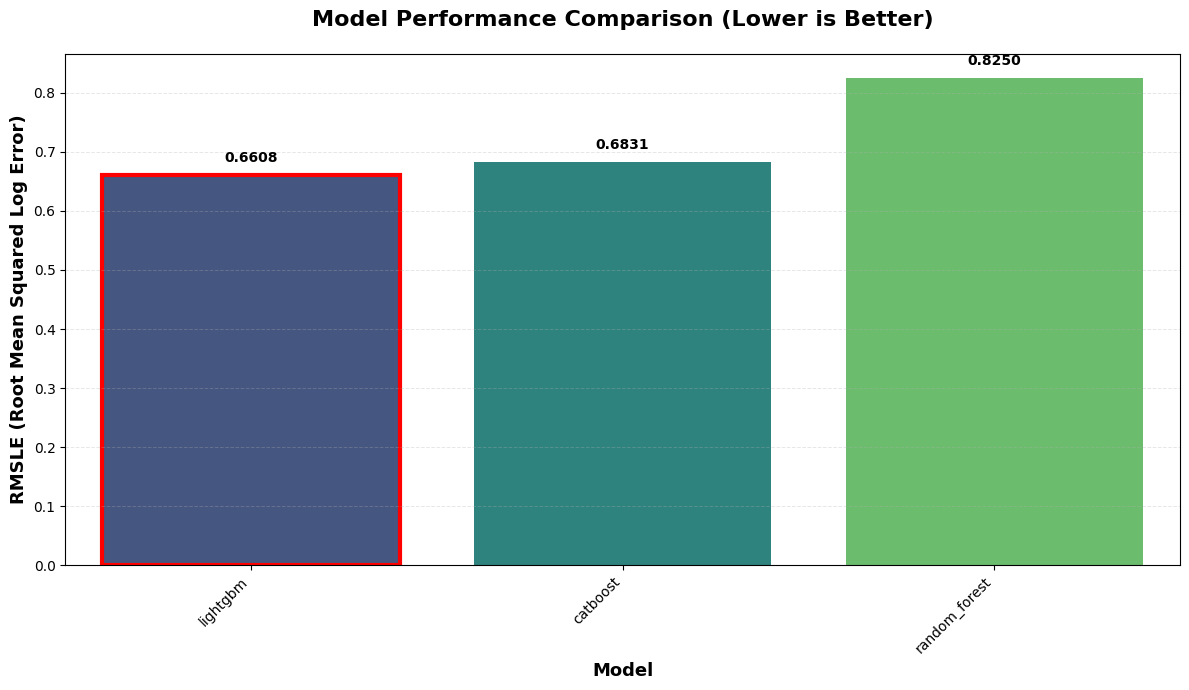


🏆 Best Model: lightgbm
   RMSLE Score: 0.6608

📊 Full Rankings:
   1. lightgbm             - RMSLE: 0.6608
   2. catboost             - RMSLE: 0.6831
   3. random_forest        - RMSLE: 0.8250


In [16]:
# Convert results to DataFrame and sort
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSLE'])
results_df = results_df.sort_values('RMSLE').reset_index(drop=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 7))
bars = sns.barplot(data=results_df, x='Model', y='RMSLE', palette='viridis', ax=ax)

# Styling
ax.set_title('Model Performance Comparison (Lower is Better)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Model', fontsize=13, fontweight='bold')
ax.set_ylabel('RMSLE (Root Mean Squared Log Error)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)

# Rotate x-labels if model names are long
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, (idx, row) in enumerate(results_df.iterrows()):
    ax.text(i, row['RMSLE'] + (results_df['RMSLE'].max() * 0.02), 
            f'{row["RMSLE"]:.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Highlight best model
best_bar = bars.patches[0]
best_bar.set_edgecolor('red')
best_bar.set_linewidth(3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*50}")
print(f"🏆 Best Model: {results_df.iloc[0]['Model']}")
print(f"   RMSLE Score: {results_df.iloc[0]['RMSLE']:.4f}")
print(f"{'='*50}")

# Show all rankings
print("\n📊 Full Rankings:")
for idx, row in results_df.iterrows():
    print(f"   {idx+1}. {row['Model']:<20} - RMSLE: {row['RMSLE']:.4f}")

In [17]:
best_model_name = results_df.iloc[0]['Model']
print(f"Retraining {best_model_name} on FULL dataset (Train + Validation)...")

# Combine Train and Val for final production model
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

# Get fresh model instance
final_model = factory.get_model(best_model_name)

# Fit on full data
final_model.fit(X_full, y_full)

# Save
save_path = '../models/best_energy_model.pkl'
joblib.dump(final_model, save_path)
file_size = os.path.getsize(save_path) / (1024 * 1024) # Size in MB
print(f"Success! Model saved. File size: {file_size:.2f} MB")

print(f"Model saved successfully to: {save_path}")
print("Ready for Phase IV: Streamlit App Deployment!")

Retraining lightgbm on FULL dataset (Train + Validation)...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.013562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 18342124, number of used features: 22
[LightGBM] [Info] Start training from score 4.569330
Success! Model saved. File size: 3.79 MB
Model saved successfully to: ../models/best_energy_model.pkl
Ready for Phase IV: Streamlit App Deployment!


In [18]:
# --- RUN IN 03_MODELING.IPYNB ---
import pandas as pd

# Load your processed data if not already in memory
# train_df = pd.read_pickle('data/processed/train_processed.pkl')

# 1. Select a specific building to visualize (e.g., Building 0, an Education building)
# We pick a slice from the validation period (Oct-Dec 2016)
validation_sample = train_df[
    (train_df['building_id'] == 0) & 
    (train_df['timestamp'] >= '2016-10-01') & 
    (train_df['timestamp'] < '2016-11-01')
].copy()

# 2. Save this small slice
validation_sample.to_pickle('../data/processed/validation_sample.pkl')
print("Saved validation_sample.pkl for the App.")

Saved validation_sample.pkl for the App.
